In [1]:
# %load_ext autoreload
# %autoreload 2
import sys
# sys.path.insert(0,'/home/michele/lavoro/code/librascal/build/')
sys.path.insert(0,'/home/nigam/git/librascal_cs/librascal/build/')

# Spherical expansion coefficients

This notebook provides examples of the kind of manipulations that need to be applied to rotate structures and spherical expansion coefficients. First, using traditional complex-spherical-harmonics tools, then, converting those to a fully real-valued pipeline based on a couple of handy utility functions.

In [2]:
from ase.io import read
import ase
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import WignerDReal, ClebschGordanReal, spherical_expansion_reshape, lm_slice, real2complex_matrix

In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [3]:
# imports also some internals to demonstrate manually some CG manipulations
from rascal.utils.cg_utils import _r2c as r2c
from rascal.utils.cg_utils import _c2r as c2r
from rascal.utils.cg_utils import _cg as clebsch_gordan
from rascal.utils.cg_utils import _rotation as rotation
from rascal.utils.cg_utils import _wigner_d as wigner_d

## Loads the structures

In [4]:
import urllib.request
# a collection of distorted ethanol molecules from the ANI-1 dataset 
# (see https://github.com/isayev/ANI1_dataset) with energies and forces computed using DFTB+ 
# (see https://www.dftbplus.org/)
url = 'https://raw.githubusercontent.com/cosmo-epfl/librascal-example-data/833b4336a7daf471e16993158322b3ea807b9d3f/inputs/molecule_conformers_dftb.xyz'
# Download the file from `url`, save it in a temporary directory and get the
# path to it (e.g. '/tmp/tmpb48zma.txt') in the `structures_fn` variable:
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmpv5k_lx8e'

In [5]:
# Total number of structure to load
N = 100

# load the structures
frames = read(structures_fn,':{}'.format(N))

## Utility functions

Numerical evaluation of rotations and CG coefficients from sympy

In [6]:
ml1, ml2, mL = 2,3,1

In [7]:
mcg = clebsch_gordan(ml1, ml2, mL)

In [8]:
mcg[:,:,2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.65465367],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.53452248,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.41403934,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.29277002,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.16903085,  0.        ,  0.        ,
         0.        ,  0.        ]])

## Demonstrate the equivariance of spherical expansion coefficients

first, we compute the density expansion coefficients on a representative dataset

In [9]:
spherical_expansion_hypers = {
    "interaction_cutoff": 3,
    "max_radial": 8,
    "max_angular": 6,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
}

spex = SphericalExpansion(**spherical_expansion_hypers)

In [10]:
selframe = frames[8]
sell = 3
feats = spex.transform(selframe).get_features(spex)
feats *= 1e6
rfeats = spherical_expansion_reshape(feats, **spherical_expansion_hypers)

In [11]:
# random rotation in terms of Euler angles
abc = np.random.uniform(size=(3))*np.pi

In [12]:
# this is the Cartesian rotation matrix (helper function, ZYZ convention)
mrot = rotation(*abc)

In [13]:
# rotated structure and associated features
rotframe = selframe.copy()
rotframe.positions = rotframe.positions @ mrot.T
rotframe.cell = rotframe.cell @ mrot.T   # rotate also the cell
rotfeats = spex.transform(rotframe).get_features(spex)
rotfeats *= 1e6
rfeats_rot = spherical_expansion_reshape(rotfeats, **spherical_expansion_hypers)

In [14]:
print(rfeats[0,0,0,lm_slice(sell)])
np.linalg.norm(rfeats[0,0,0,lm_slice(sell)])

[  49.95020279    3.36703957  -14.28548994  -32.00290346 -349.96433675
   38.64396967  463.2326373 ]


585.0534081728395

In [15]:
print(rfeats_rot[0,0,0,lm_slice(sell)])
np.linalg.norm(rfeats_rot[0,0,0,lm_slice(sell)])

[  68.55691222  175.79580883  140.54759028  -94.97238342 -464.69499335
 -243.87115309  -49.95316707]


585.0534081728388

## Rotate the spherical expansion features using Wigner matrices

In [16]:
# computing the wigner matrix takes some time for L>4
mwd = wigner_d(sell, *abc)

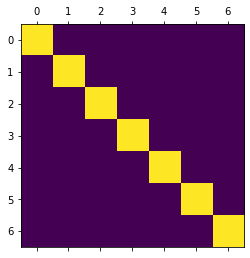

In [17]:
# orthogonality
plt.matshow(np.real(np.conjugate(mwd.T)@mwd))

In [18]:
#  back and forth to check transformation from real to complex SPH
c2r(r2c(rfeats[0,0,0,lm_slice(sell)])) - rfeats[0,0,0,lm_slice(sell)]

array([0., 0., 0., 0., 0., 0., 0.])

In [19]:
rfeats[0,0,0,lm_slice(sell)]

array([  49.95020279,    3.36703957,  -14.28548994,  -32.00290346,
       -349.96433675,   38.64396967,  463.2326373 ])

In [20]:
rfeats_rot[0,0,0,lm_slice(sell)]

array([  68.55691222,  175.79580883,  140.54759028,  -94.97238342,
       -464.69499335, -243.87115309,  -49.95316707])

In [21]:
c2r(np.conjugate(mwd)@r2c(rfeats[0,0,0,lm_slice(sell)]))

array([  68.55691222,  175.79580883,  140.54759028,  -94.97238342,
       -464.69499335, -243.87115309,  -49.95316707])

## Compute CG iteration and show that it transforms properly

basically, here we compute covariant, lambda-SOAP features by combining spherical expansion coefficients,
following the idea behind NICE [[original paper](doi.org/10.1063/5.0021116)]

In [22]:
# these are the indices of the features 
ml1, ml2, mL = 3,2,3
mcg = clebsch_gordan(ml1, ml2, mL)
mwd = wigner_d(mL, *abc)

In [23]:
cg1 = c2r(np.einsum("abc,a,b->c",mcg,
                    r2c(rfeats[0,0,0,lm_slice(ml1)]), 
                    r2c(rfeats[0,0,0,lm_slice(ml2)])))

In [24]:
rotcg1 = c2r(np.einsum("abc,a,b->c",mcg,
                    r2c(rfeats_rot[0,0,0,lm_slice(ml1)]), 
                    r2c(rfeats_rot[0,0,0,lm_slice(ml2)])) )

In [25]:
cg1

array([ -27558.89898463,   -1200.96265403,    5846.63967851,
         12867.0974336 ,  157208.67054923,  -18469.14931726,
       -206676.68144291])

In [26]:
rotcg1

array([-31688.90500193, -75867.59901128, -61891.50360385,  39438.13939809,
       208326.28347923, 112645.7494379 ,  22286.70565312])

In [27]:
c2r(np.conjugate(mwd)@r2c(cg1))

array([-31688.90500193, -75867.59901128, -61891.50360385,  39438.1393981 ,
       208326.28347923, 112645.7494379 ,  22286.70565312])

## Direct real transformations

There's no "real" reason to go through the complex algebra for rotations - we can transform once and for all the coefficients and be done with that!

In [28]:
# matrix version of the real-2-complex and complex-2-real transformations
r2c_mat = np.hstack([r2c(np.eye(2*mL+1)[i])[:,np.newaxis] for i in range(2*mL+1)])
c2r_mat = np.conjugate(r2c_mat.T)

In [29]:
# we can use this to transform features
r2c_mat@cg1 - r2c(cg1)

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [30]:
# and Wigner D matrix as well
real_mwd = np.real(c2r_mat @ np.conjugate(mwd) @ r2c_mat)

The direct real rotation is equal (modulo noise) to going back and forth from complex sph

In [31]:
real_mwd @ cg1 - rotcg1

array([-5.45696821e-11, -1.74622983e-10, -1.89174898e-10,  4.14729584e-10,
        5.23868948e-10,  2.03726813e-10,  2.54658516e-11])

this also applies to the CG iteration!

In [32]:
r2c_mat_l1 = np.hstack([r2c(np.eye(2*ml1+1)[i])[:,np.newaxis] for i in range(2*ml1+1)])
r2c_mat_l2 = np.hstack([r2c(np.eye(2*ml2+1)[i])[:,np.newaxis] for i in range(2*ml2+1)])
r2c_mat_L = np.hstack([r2c(np.eye(2*mL+1)[i])[:,np.newaxis] for i in range(2*mL+1)])

In [33]:
real_mcg = np.real(np.einsum("abc, ax, by, zc -> xyz", mcg, r2c_mat_l1, r2c_mat_l2, np.conjugate(r2c_mat_L.T)))

In [34]:
real_cg1 = np.einsum("abc,a,b->c",real_mcg,
                    rfeats[0,0,0,lm_slice(ml1)],
                    rfeats[0,0,0,lm_slice(ml2)])

In [35]:
real_cg1 - cg1

array([ 3.63797881e-12,  4.54747351e-13, -2.72848411e-12,  0.00000000e+00,
       -5.82076609e-11,  3.63797881e-12,  5.82076609e-11])

# Streamlined real-only CG iter (and transformation)

Uses the utility classes defined in rascal.utils to do all of the above (and more!)
WignerDReal is a Wigner D matrix implementation to rotate Y^m_l - like coefficients
ClebschGordanReal precomputes Clebsch-Gordan operations using real-only storage of the spherical expansion coefficients

In [36]:
WD   = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)
CGIR = ClebschGordanReal(spherical_expansion_hypers["max_angular"])

In [37]:
scale = 1
test_feats = [ rfeats[0,0,0,l**2:(l+1)**2] *scale  for l in range(0,5) ]
test_feats_rot = [ rfeats_rot[0,0,0,l**2:(l+1)**2]*scale  for l in range(0,5) ]

In [38]:
t1 = CGIR.combine(test_feats[3], test_feats[4], 3)
t1_r = CGIR.combine(test_feats_rot[3], test_feats_rot[4], 3)

In [39]:
t1

array([ 18281.34900888,    999.41629989,  -4430.72718297,  -5687.44611687,
       -65424.57645254,   7093.39913746,  81940.0786862 ])

In [40]:
WD.rotate(t1)

array([ 12008.54023124,  28309.94429868,  23027.09351422, -11780.34416301,
       -84486.23061345, -50220.97843956, -12541.99282247])

In [41]:
t1_r

array([ 12008.54023124,  28309.94429868,  23027.09351422, -11780.34416301,
       -84486.23061345, -50220.97843956, -12541.99282247])

In [42]:
t2 = CGIR.combine(t1, test_feats[3], 2)
t2_r = CGIR.combine(t1_r, test_feats_rot[3], 2)

In [43]:
WD.rotate(t2)

array([-4146185.99559896, -6236572.66312225, 13607687.78067045,
       21321956.62734299,  6638083.96454762])

In [44]:
t2_r

array([-4146185.99559896, -6236572.66312223, 13607687.7806704 ,
       21321956.62734293,  6638083.96454761])

In [45]:
t3 = CGIR.combine(t2, test_feats[3], 1)
t3_r = CGIR.combine(t2_r, test_feats_rot[3], 1)

In [46]:
WD.rotate(t3)

array([ 1.45634104e+09, -6.69879061e+09, -4.25175719e+09])

In [47]:
t3_r

array([ 1.45634104e+09, -6.69879061e+09, -4.25175719e+09])

In [48]:
t4 = CGIR.combine(t3, t2, 3)
t4_r = CGIR.combine(t3_r, t2_r, 3)

In [49]:
WD.rotate(t4)

array([ 1.93011091e+16,  4.92727261e+16,  4.15900931e+16, -2.60040488e+16,
       -1.34645650e+17, -7.27694244e+16, -1.56873481e+16])

In [50]:
t4_r

array([ 1.93011091e+16,  4.92727261e+16,  4.15900931e+16, -2.60040488e+16,
       -1.34645650e+17, -7.27694244e+16, -1.56873481e+16])

# Bulk calculation of features

the combination can also be done in bulk! This does it combining elementwise (basically computing the diagonal squares of the features)

In [51]:
t1_bulk = CGIR.combine(rfeats[:,:,:,lm_slice(3)], rfeats[:,:,:,lm_slice(2)], 3)

In [52]:
t1_bulk.shape

(10, 3, 8, 7)

## Manually compute SOAP and check they match librascal's

In [53]:
soap_hypers = deepcopy(spherical_expansion_hypers)

soap_hypers["soap_type"] = "PowerSpectrum"
soap_hypers["normalize"] = False

soap = SphericalInvariants(**soap_hypers)
soap_feats = soap.transform(selframe).get_features(soap)*1e12  # scale

In [54]:
nel = len(set(selframe.symbols))
elidx = np.triu_indices(nel)
tsoap = np.moveaxis(np.asarray([
 CGIR.combine_einsum(rfeats[:,:,:,lm_slice(l)], rfeats[:,:,:,lm_slice(l)], 0, 
                     "ian,iAN->ianAN")
 for l in range(soap_hypers["max_angular"]+1)  
]),(1,2,4,3,5,0,6),(0,1,2,3,4,5,6))[:,elidx[0],elidx[1],...].reshape((len(selframe), -1))

In [55]:
tsoap.shape

(10, 2688)

In [56]:
soap_feats[0,:20]

array([ 5.14297164e+05,  5.02747640e+05,  3.37580007e+05,  1.29372511e+05,
        6.19621600e+04,  1.49085546e+04,  6.20592789e+03,  9.65090901e+05,
        1.07108648e+06,  6.37862770e+05,  2.55285918e+05,  7.15559213e+04,
        1.24025282e+04, -2.10003182e+03,  3.30111098e+06,  3.77011554e+06,
        2.91060831e+06,  1.40933352e+06,  7.17054445e+05,  2.15820164e+05])

In [57]:
tsoap[0,:20]

array([ 5.14297164e+05, -5.02747640e+05,  3.37580007e+05, -1.29372511e+05,
        6.19621600e+04, -1.49085546e+04,  6.20592789e+03,  9.65090901e+05,
       -1.07108648e+06,  6.37862770e+05, -2.55285918e+05,  7.15559213e+04,
       -1.24025282e+04, -2.10003182e+03,  3.30111098e+06, -3.77011554e+06,
        2.91060831e+06, -1.40933352e+06,  7.17054445e+05, -2.15820164e+05])

In [58]:
r2c_mats = {}
c2r_mats = {}
for L in range(0, soap_hypers["max_angular"]+1 + 1):
    r2c_mats[L] = real2complex_matrix(L)
    c2r_mats[L] = np.conjugate(r2c_mats[L]).T

In [59]:
soap_manual_full =  np.moveaxis(np.asarray([
    np.real(np.einsum("ianm,iANm->ianAN",
              rfeats[...,lm_slice(l)]@r2c_mats[l], 
              np.conjugate(rfeats[...,lm_slice(l)]@r2c_mats[l])
             ))/np.sqrt(2*l+1)
    for l in range(soap_hypers["max_angular"]+1)]),
    (1,2,4,3,5,0),(0,1,2,3,4,5))

In [60]:
soap_manual_complex_2013 =  np.moveaxis(np.asarray([
    np.real(np.einsum("ianm,iANm->ianAN",
              rfeats[...,lm_slice(l)]@r2c_mats[l].T, 
              np.conjugate(rfeats[...,lm_slice(l)]@r2c_mats[l])
             ))/np.sqrt(2*l+1)
    for l in range(soap_hypers["max_angular"]+1)]),
    (1,2,4,3,5,0),(0,1,2,3,4,5))[:,elidx[0],elidx[1],...].reshape((len(selframe), -1))    

In [61]:
rfeats[0,0,0,lm_slice(1)].mean()

338.7864874642926

## $\lambda$-SOAP

#### Tests on SPH

It's important to know how the r2c, c2r should be used with $Y_l^m$ and $Y_l^{m*}$ to go from complex to real and vice versa. 

From the following, since $\langle{a nl -m}|\rho_i\rangle{} \propto Y_l^{m}$, we use forward multiplication with c2r_mats[l] to go from complex to real 

In [62]:
import scipy
def sph(l, theta, phi):
    ylm=np.zeros((2*l+1), complex)
    for m in range(-l, l+1):
        ylm[m+l] = scipy.special.sph_harm(m,l,phi,theta)
    return ylm

In [63]:
lam=1

In [64]:
ylm= sph(lam, np.pi/4, np.pi/3)
ylm_conj = np.conjugate(ylm)

In [65]:
ylm

array([ 0.12215063-0.21157109j,  0.34549415+0.j        ,
       -0.12215063-0.21157109j])

In [66]:
r2c_mats[lam]@(c2r_mats[lam]@ylm) #== ylm

array([ 0.12215063-0.21157109j,  0.34549415+0.j        ,
       -0.12215063-0.21157109j])

In [67]:
(ylm_conj@r2c_mats[lam])@c2r_mats[lam] #== ylm_conj

array([ 0.12215063+0.21157109j,  0.34549415+0.j        ,
       -0.12215063+0.21157109j])

In [68]:
def combine_SPH(yl1,yl2, lam, mycg):
    cl = np.zeros((2*lam+1), dtype = complex )
    if (l1,l2,lam) in mycg._cgraw:
        cg = mycg._cgraw[(l1,l2,lam)]   
        cl = np.einsum("m,p,mpM->M",yl1, yl2, cg)
    return cl

In [69]:
l1=2
l2=4
lam=2
yl1= sph(l1, np.pi/4, np.pi/3)
yl2= sph(l2, np.pi/5, np.pi/6)
combine_SPH(yl1,yl2, lam, CGIR)@c2r_mats[lam].T #combination of SPH

array([0.01480892+0.00000000e+00j, 0.01447991+3.77027992e-18j,
       0.12909782+1.73472348e-17j, 0.20347965-3.74376998e-18j,
       0.0800665 -8.67361738e-19j])

In [70]:
combine_SPH(yl1.conj(),yl2.conj(), lam, CGIR)@r2c_mats[lam] #combination of SPH conjugates(should be conjugate of above)

array([0.01480892+0.00000000e+00j, 0.01447991-3.77027992e-18j,
       0.12909782-1.73472348e-17j, 0.20347965+3.74376998e-18j,
       0.0800665 +8.67361738e-19j])

this instead uses a more general core iteration based on einsum. This below is basically lambda-SOAP

Want $\lambda$-SOAP? You've got it! This computes the full set of features (many will be zeros but oh well) using CG iteration. Input spherical harmonics should be already "unrolled" into a n_env, n_el, n_max, (lmax+1)^2 form.
Result is also returned fully unrolled, the first index being the environment, and the last the lambda-SOAP mu index.

*Note this may differ from existing definitions because of the scaling of coefficients*

In [71]:
cc = rfeats[...,lm_slice(3)]@r2c_mats[3].T

In [72]:
cc[0,1,1,]

array([-131.58630556 -18.17952726j,   -3.73066751  +3.21706873j,
        -62.58577776-112.6311509j ,   -5.08103771  +0.j        ,
         62.58577776-112.6311509j ,   -3.73066751  -3.21706873j,
        131.58630556 -18.17952726j])

In [73]:
rfeats[0,1,1,lm_slice(3)]@r2c_mats[3].T

array([-131.58630556 -18.17952726j,   -3.73066751  +3.21706873j,
        -62.58577776-112.6311509j ,   -5.08103771  +0.j        ,
         62.58577776-112.6311509j ,   -3.73066751  -3.21706873j,
        131.58630556 -18.17952726j])

In [74]:
r2c(rfeats[0,1,1,lm_slice(3)])

array([-131.58630556 -18.17952726j,   -3.73066751  +3.21706873j,
        -62.58577776-112.6311509j ,   -5.08103771  +0.j        ,
         62.58577776-112.6311509j ,   -3.73066751  -3.21706873j,
        131.58630556 -18.17952726j])

In [75]:
def lambda_soap_manual(spx, lam, mycg):
    lmax = int(np.sqrt(spx.shape[-1]))-1
    nid, nel, nmax = spx.shape[:-1]
    lsoap = np.zeros((nid, nel, nmax, lmax+1, nel, nmax, lmax+1, 2*lam+1), dtype = complex )
    for l1 in range(lmax+1):
        cspx1 = spx[..., lm_slice(l1)]@r2c_mats[l1].T
        for l2 in range(lmax+1):            
            if (l1,l2,lam) in mycg._cgraw:
                cg = mycg._cgraw[(l1,l2,lam)]   
                #cspx2 = np.conjugate(spx[..., lm_slice(l2)]@r2c_mats[l2])                
                cspx2 = spx[..., lm_slice(l2)]@r2c_mats[l2].T
                lsoap[:,:,:,l1,:,:,l2] += np.einsum("ianm,iANp,mpM->ianANM",
                                                   cspx1, cspx2, cg)@c2r_mats[lam].T
    return lsoap

In [76]:
def lambda_soap_indirect(spx, lam, mycg):
    lmax = int(np.sqrt(spx.shape[-1]))-1
    nid, nel, nmax = spx.shape[:-1]
    lsoap = np.zeros((nid, nel, nmax, lmax+1, nel, nmax, lmax+1, 2*lam+1), dtype = complex )
    for l1 in range(lmax+1):
        cspx1 = spx[..., lm_slice(l1)]
        for l2 in range(lmax+1):            
            if (l1,l2,lam) in mycg._cgraw:
                cg = np.einsum("abc, ax, by, zc -> xyz", mycg._cgraw[(l1,l2,lam)],
                               r2c_mats[l1],r2c_mats[l2], c2r_mats[lam] )
                #cspx2 = np.conjugate(spx[..., lm_slice(l2)]@r2c_mats[l2])                
                cspx2 = spx[..., lm_slice(l2)]
                lsoap[:,:,:,l1,:,:,l2] += np.einsum("ianm,iANp,mpM->ianANM",
                                                   cspx1, cspx2, cg)
    return lsoap

In [77]:
def lambda_soap(spx, lam, cg):
    lmax = int(np.sqrt(spx.shape[-1]))-1
    nid, nel, nmax = spx.shape[:-1]
    lsoap = np.zeros((nid, nel, nmax, lmax+1, nel, nmax, lmax+1, 2*lam+1))
    for l1 in range(lmax+1):
        for l2 in range(lmax+1):            
            lsoap[:,:,:,l1,:,:,l2] = cg.combine_einsum(spx[..., lm_slice(l1)],
                                        spx[..., lm_slice(l2)], 
                                        lam, combination_string="ian,iAN->ianAN")
    return lsoap

In [78]:
lam=0

In [79]:
ss = lambda_soap_manual(rfeats, lam, CGIR)
s2 = lambda_soap_indirect(rfeats, lam, CGIR)

In [80]:
lsoap = lambda_soap(rfeats, lam, CGIR)

In [81]:
l1=1
l2=1
a1=0
n1=1
a2=0
n2=0
atom_idx=0

In [82]:
ss[atom_idx,a1,n1,l1,a2,n2,l2]

array([-1071086.47615587+0.j])

In [83]:
s2[atom_idx,a1,n1,l1,a2,n2,l2]

array([-1071086.47615587+0.j])

In [84]:
lsoap[atom_idx,a1,n1,l1,a2,n2,l2]

array([-1071086.47615587])

In [85]:
ss.shape

(10, 3, 8, 7, 3, 8, 7, 1)

In [86]:
lsoap.shape

(10, 3, 8, 7, 3, 8, 7, 1)

In [87]:
lsoap[0,0,1,1,1,1,1]

array([-111637.22357172])

In [88]:
ss[0,0,1,1,1,1,1]

array([-111637.22357172+0.j])

In [89]:
s2[0,0,1,1,1,1,1]

array([-111637.22357172+0.j])

In [90]:
soap_manual_full[0,0,1,1,1,1]

111637.22357172177

### Check that we can recover invariant SOAP from $\lambda$ SOAP

In [91]:
inv=np.zeros((10, 3, 8, 3, 8,7), complex)
nel = len(set(selframe.symbols))
elidx = np.triu_indices(nel)
for l in range(7):
    inv[:,:,:,:,:,l] = ss[:,:,:,l,:,:,l,0] 
inv=np.moveaxis(inv, (0,1,2,3,4,5),(0,1,4,2,3,5))[:,elidx[0],elidx[1],...].reshape((len(selframe), -1))

In [92]:
inv[0, :20]

array([ 5.14297164e+05+0.00000000e+00j, -5.02747640e+05+0.00000000e+00j,
        3.37580007e+05+0.00000000e+00j, -1.29372511e+05+0.00000000e+00j,
        6.19621600e+04+0.00000000e+00j, -1.49085546e+04+0.00000000e+00j,
        6.20592789e+03+0.00000000e+00j,  9.65090901e+05+0.00000000e+00j,
       -1.07108648e+06+0.00000000e+00j,  6.37862770e+05+0.00000000e+00j,
       -2.55285918e+05+0.00000000e+00j,  7.15559213e+04+0.00000000e+00j,
       -1.24025282e+04+0.00000000e+00j, -2.10003182e+03+0.00000000e+00j,
        3.30111098e+06+0.00000000e+00j, -3.77011554e+06+0.00000000e+00j,
        2.91060831e+06+0.00000000e+00j, -1.40933352e+06+3.63797881e-12j,
        7.17054445e+05+0.00000000e+00j, -2.15820164e+05+0.00000000e+00j])

In [93]:
tsoap[0,:20]

array([ 5.14297164e+05, -5.02747640e+05,  3.37580007e+05, -1.29372511e+05,
        6.19621600e+04, -1.49085546e+04,  6.20592789e+03,  9.65090901e+05,
       -1.07108648e+06,  6.37862770e+05, -2.55285918e+05,  7.15559213e+04,
       -1.24025282e+04, -2.10003182e+03,  3.30111098e+06, -3.77011554e+06,
        2.91060831e+06, -1.40933352e+06,  7.17054445e+05, -2.15820164e+05])

### sum rules

In [94]:
lsoap = {L:lambda_soap(rfeats, L, CGIR) for L in range(6)}

In [95]:
rfeats.shape

(10, 3, 8, 49)

In [96]:
normrho = np.sum(rfeats[0,1,2,lm_slice(2)]**2)
print(normrho**2)

6368238661915.708


WIP

In [97]:
normlsoap = np.sum([
    (lsoap[L][0,1,2,2,1,2,2]**2).sum()
    for L in range(6)
] )
print(normlsoap)
print(normlsoap - normrho**2)

6368238661915.705
-0.0029296875


In [98]:
lsoap[0].shape

(10, 3, 8, 7, 3, 8, 7, 1)

In [99]:
%%time
lsoap = lambda_soap(rfeats, 3, CGIR)
lsoap.shape = (lsoap.shape[0], -1, lsoap.shape[-1])
lsoap_rot = lambda_soap(rfeats_rot, 3, CGIR)
lsoap_rot.shape = (lsoap_rot.shape[0], -1, lsoap_rot.shape[-1])

CPU times: user 88.5 ms, sys: 12 ms, total: 101 ms
Wall time: 99.6 ms


In [100]:
lsoap[0,101]

array([ 1.96635884e+06, -1.14632534e+04, -8.94558593e+05,  5.91501302e+02,
        2.03481856e+06, -2.80053405e+03, -6.91619966e+05])

In [101]:
WD.rotate(lsoap[0,101])

array([  -24471.84413669,  -310651.95708875, -2338453.14090476,
        1617394.05940433,   992824.79365816,  -336222.1295346 ,
          74766.16593048])

In [102]:
lsoap_rot[0,101]

array([  -24471.84413668,  -310651.95708875, -2338453.14090476,
        1617394.05940433,   992824.79365816,  -336222.1295346 ,
          74766.16593048])

## Bispectrum

In [103]:
bspect_hypers = deepcopy(spherical_expansion_hypers)

bspect_hypers["soap_type"] = "BiSpectrum"
bspect_hypers["normalize"] = False
bspect_hypers["inversion_symmetry"] = False

bspect = SphericalInvariants(**bspect_hypers)
bspect_feats = bspect.transform(selframe).get_features(bspect)*1e18  # scale

In [104]:
def bispectrum_manual_real(spx, cg_dict):
    combination_string="ian,iAN,iBM-> iaABnNM"
    lmax = int(np.sqrt(spx.shape[-1]))-1
    rho_shape = np.einsum(combination_string,spx[...,0], spx[...,0], spx[...,0] ).shape
    bispectrum = []
    nid, nel, nmax = rfeats.shape[:-1]
    relevant_l=[]
    for l1 in range(lmax+1):
        for l2 in range(lmax+1):
            for l3 in range(lmax+1):
                bispl1l2l3 =  np.zeros(rho_shape)
                rho1 = spx[..., lm_slice(l1)]
                rho2 = spx[..., lm_slice(l2)]
                rho3 = spx[...,lm_slice(l3)]
                rho = np.zeros(rho_shape)
                if (l1, l2, l3) in cg_dict:
                    relevant_l.append([l1,l2,l3])
                    for m3 in range(2 * l3 + 1):
                        for m1, m2, cg in cg_dict[(l1, l2, l3)][m3]:
                            rho[...] += np.einsum(
                                combination_string,  rho1[...,m1], rho2[..., m2], rho3[..., m3])* cg
                    bispl1l2l3 =rho[...]/np.sqrt(2*l3+1)*(-1)**l3
                    bispectrum.append(bispl1l2l3)
    #bispectrum = np.moveaxis(np.asarray(bispectrum),(3,7,4,8,5,6),(4,3,5,6,7,8))
    return np.asarray(bispectrum)#,relevant_l

In [105]:
cg_dict=CGIR._cgdict
bispectrum1_real=bispectrum_manual_real(rfeats, cg_dict)

In [106]:
def bispectrum_from_lsoap_real(spx,cg):
    lmax = int(np.sqrt(spx.shape[-1]))-1
    combination_string="ian,iAN,iBM-> ianANBM"
    rho_shape = np.einsum(combination_string,spx[...,0], spx[...,0], spx[...,0]).shape
    bispectrum = []
    bispl1l2l3 = np.moveaxis(np.zeros(rho_shape+(lmax+1,lmax+1,lmax+1)),(3,7,4,8,5,6),(4,3,5,6,7,8))
    cg_dict = cg._cgdict
    for l3 in range(lmax+1):
        lsoap = lambda_soap(spx, l3, cg)
        bispl1l2l3[...,l3] = np.einsum("ianlANLM, iBKM->ianlANLBK", lsoap[...,:], spx[...,lm_slice(l3)])*(-1)**l3/np.sqrt(2*l3+1)
        for l1 in range(lsoap.shape[3]):
            for l2 in range(lsoap.shape[-2]):
                if (l1,l2,l3) in cg_dict: 
                    bispectrum.append(np.moveaxis(bispl1l2l3[:,:,:,l1,:,:,l2,:,:,l3], (2,3,4,5),(4,2,5,3)))
    return np.asarray(bispectrum)

In [107]:
bispectrum2_real= bispectrum_from_lsoap_real(rfeats,CGIR)

In [108]:
bispectrum2_real.shape

(175, 10, 3, 3, 3, 8, 8, 8)

In [109]:
bispectrum1_real.shape

(175, 10, 3, 3, 3, 8, 8, 8)

In [110]:
np.sort(bispectrum2_real[0].flatten())[-100:]
# bispectrum2_real[0].flatten()[-100:]

array([9.68183527e+11, 9.68183527e+11, 9.68183527e+11, 9.71774729e+11,
       9.71774729e+11, 9.71774729e+11, 9.93330751e+11, 9.93330751e+11,
       9.93330751e+11, 1.01873572e+12, 1.01873572e+12, 1.01873572e+12,
       1.03233253e+12, 1.03233253e+12, 1.03233253e+12, 1.06162208e+12,
       1.06162208e+12, 1.06162208e+12, 1.09884470e+12, 1.09884470e+12,
       1.09884470e+12, 1.11553116e+12, 1.11553116e+12, 1.11553116e+12,
       1.13241319e+12, 1.13241319e+12, 1.13241319e+12, 1.14923038e+12,
       1.14923038e+12, 1.14923038e+12, 1.20378854e+12, 1.20378854e+12,
       1.20378854e+12, 1.21634598e+12, 1.21634598e+12, 1.21634598e+12,
       1.37697252e+12, 1.37697252e+12, 1.37697252e+12, 1.46003362e+12,
       1.46003362e+12, 1.46003362e+12, 1.53563306e+12, 1.53563306e+12,
       1.53563306e+12, 1.57852220e+12, 1.57852220e+12, 1.57852220e+12,
       1.60389490e+12, 1.60389490e+12, 1.60389490e+12, 1.61756932e+12,
       1.61756932e+12, 1.61756932e+12, 1.61850819e+12, 1.61850819e+12,
      

In [111]:
np.sort(bispectrum1_real[0].flatten())[-100:]
# bispectrum1_real[0].flatten()[:100]

array([9.68183527e+11, 9.68183527e+11, 9.68183527e+11, 9.71774729e+11,
       9.71774729e+11, 9.71774729e+11, 9.93330751e+11, 9.93330751e+11,
       9.93330751e+11, 1.01873572e+12, 1.01873572e+12, 1.01873572e+12,
       1.03233253e+12, 1.03233253e+12, 1.03233253e+12, 1.06162208e+12,
       1.06162208e+12, 1.06162208e+12, 1.09884470e+12, 1.09884470e+12,
       1.09884470e+12, 1.11553116e+12, 1.11553116e+12, 1.11553116e+12,
       1.13241319e+12, 1.13241319e+12, 1.13241319e+12, 1.14923038e+12,
       1.14923038e+12, 1.14923038e+12, 1.20378854e+12, 1.20378854e+12,
       1.20378854e+12, 1.21634598e+12, 1.21634598e+12, 1.21634598e+12,
       1.37697252e+12, 1.37697252e+12, 1.37697252e+12, 1.46003362e+12,
       1.46003362e+12, 1.46003362e+12, 1.53563306e+12, 1.53563306e+12,
       1.53563306e+12, 1.57852220e+12, 1.57852220e+12, 1.57852220e+12,
       1.60389490e+12, 1.60389490e+12, 1.60389490e+12, 1.61756932e+12,
       1.61756932e+12, 1.61756932e+12, 1.61850819e+12, 1.61850819e+12,
      

In [112]:
np.sort(np.abs(bspect_feats))[0,-100:]

array([2.90586638e+11, 2.91148510e+11, 2.91148510e+11, 3.02336767e+11,
       3.02336767e+11, 3.02750608e+11, 3.02750608e+11, 3.03553573e+11,
       3.05526400e+11, 3.06361782e+11, 3.09120570e+11, 3.11963191e+11,
       3.26007281e+11, 3.26007281e+11, 3.27784685e+11, 3.28225075e+11,
       3.30141209e+11, 3.35705006e+11, 3.35705006e+11, 3.42852300e+11,
       3.47663470e+11, 3.54368207e+11, 3.59089165e+11, 3.67739531e+11,
       3.70945336e+11, 3.72175299e+11, 3.72175299e+11, 3.75482736e+11,
       3.75482736e+11, 3.79418373e+11, 3.79418373e+11, 3.80484985e+11,
       3.80484985e+11, 3.85195688e+11, 3.86711667e+11, 3.86711667e+11,
       3.88529771e+11, 3.90845534e+11, 3.91922463e+11, 3.98451958e+11,
       4.06137396e+11, 4.12338807e+11, 4.13938265e+11, 4.18175816e+11,
       4.22512473e+11, 4.22512473e+11, 4.27809765e+11, 4.32517261e+11,
       4.32847150e+11, 4.37651858e+11, 4.49301685e+11, 4.49301685e+11,
       4.50708454e+11, 4.50708454e+11, 4.56712874e+11, 4.56712874e+11,
      

# Products of features

This is useful to transform quantities that can be construed as products of spherical harmonics to a coupled form, and back. That is, if you have Y^m1_l1 Y^m2_l2 you can cast it into a series of coefficients that transform like a single Y^M_L, and back. Note that the transformation depends on the initial values of l1,l2

In [113]:
scale = 1e0
test_feats = [ rfeats[0,0,0,lm_slice(l)] *scale  for l in range(0,5) ]
test_feats_rot = [ rfeats_rot[0,0,0,lm_slice(l)]*scale  for l in range(0,5) ]

test_prod = test_feats[2][:,np.newaxis]@test_feats[3][np.newaxis,:]
test_prod_rot = test_feats_rot[2][:,np.newaxis]@test_feats_rot[3][np.newaxis,:]

In [114]:
test_coupled = CGIR.couple(test_prod)

In [115]:
test_coupled[1]

{1: array([  1116.97266153,   9182.66418359, 257291.01929584]),
 2: array([  -35.01233816,  2828.86974201,   490.10996308, 14611.9089392 ,
         -767.50231429]),
 3: array([ -27558.89898463,   -1200.96265403,    5846.63967851,
          12867.0974336 ,  157208.67054923,  -18469.14931726,
        -206676.68144291]),
 4: array([  654.29805779, -7202.14472393,   362.06179569,  2653.03803833,
         1075.28740649,  8613.65658104, -1434.97953703, -8265.52573615,
          196.13187896]),
 5: array([  59173.23063602,    5671.61224113,  -26538.2726145 ,
          -3396.16257745,    8205.69769318,   23246.62736235,
         165340.37697962,  -31408.00297561, -178506.64997609,
          26363.61524319,  239148.83025647])}

In [116]:
test_coupled_rot = CGIR.couple(test_prod_rot)

In [117]:
test_coupled_rot[1][3]

array([-31688.90500193, -75867.59901128, -61891.50360385,  39438.13939809,
       208326.28347923, 112645.7494379 ,  22286.70565312])

In [118]:
WD.rotate(test_coupled[1][3])

array([-31688.90500193, -75867.59901128, -61891.50360385,  39438.1393981 ,
       208326.28347923, 112645.7494379 ,  22286.70565312])

In [119]:
test_decoupled = CGIR.decouple(test_coupled)

In [120]:
test_prod - test_decoupled

array([[ 1.27329258e-11, -4.20641300e-12,  4.77484718e-11,
        -1.81898940e-12, -1.45519152e-11,  2.27373675e-12,
         2.18278728e-11],
       [ 1.50635060e-12, -3.23474580e-11,  1.70530257e-12,
         3.46744855e-12, -6.82121026e-13,  0.00000000e+00,
         1.36424205e-12],
       [-1.09139364e-11, -1.36424205e-12,  2.72848411e-12,
        -1.81898940e-12,  5.82076609e-11, -7.27595761e-12,
        -2.91038305e-11],
       [ 1.36424205e-12, -3.52429197e-12, -3.41060513e-13,
        -6.82121026e-13, -1.09139364e-11, -3.68345354e-11,
         1.45519152e-11],
       [ 2.18278728e-11,  1.36424205e-12, -7.27595761e-12,
        -7.27595761e-12, -1.16415322e-10,  1.09139364e-11,
         1.74622983e-10]])

In [121]:
l1, l2 = 2, 3

this can be shown by seeing that the real CG are orthogonal

In [122]:
prod = np.zeros((2*l1+1,2*l2+1,2*l1+1,2*l2+1))
for L in range(abs(l1-l2), abs(l1+l2)+1):
    for M in range(0, 2*L+1):
        for m1, m2, mcg in CGIR._cgdict[(l1, l2, L)][M]:
            for m1p, m2p, mcgp in CGIR._cgdict[(l1, l2, L)][M]:
                prod[m1,m2,m1p,m2p] += mcg*mcgp

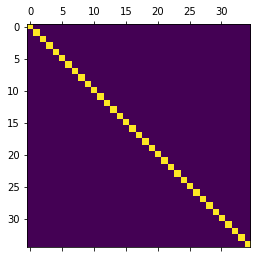

In [123]:
pr = prod.reshape((2*l1+1)*(2*l2+1),(2*l1+1)*(2*l2+1))
plt.matshow(pr)